# 3D Tomography Experiments

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pmcx
from utils import add_ball_to_array

In [ ]:
region = np.zeros((100, 100, 100))
region = add_ball_to_array(region, (50, 50, 50), 10, 1)
region = add_ball_to_array(region, (20, 20, 50), 5, 1)
plt.imshow(region[:, :, 50])
plt.show()

## Junk

In [ ]:
pmcx.gpuinfo()

In [29]:
# prop: (µa, µs, g, n)

prop = np.array([
    [0,0,1,1], # air
    [0.0200,  9.0000,  0.8900,  1.3700]]) # gray matter
cfg = {
       'nphoton': 1000000,
       'vol':np.ones([1,60,60],dtype='uint8'),
       'tstart':0,
       'tend':5e-9,
       'tstep':5e-9,
       'srcpos': [0,30,0],
       'srcdir':[0,0,1],
       'prop': prop,
       # 'detpos': [[0,30,30, 2],[0,30,30,2], [0,30,0,2]],
       'issavedet': 0,
       'issrcfrom0': 1
       }
res = pmcx.mcxlab(cfg)


nphoton: 1e+06
tstart: 0
tstep: 5e-09
tend: 5e-09
issrcfrom0: 1
srcpos: [0, 30, 0, 1]
srcdir: [0, 0, 1, 0]
issavedet: 0
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #


In [18]:
res['flux'].shape

(1, 60, 60, 1)

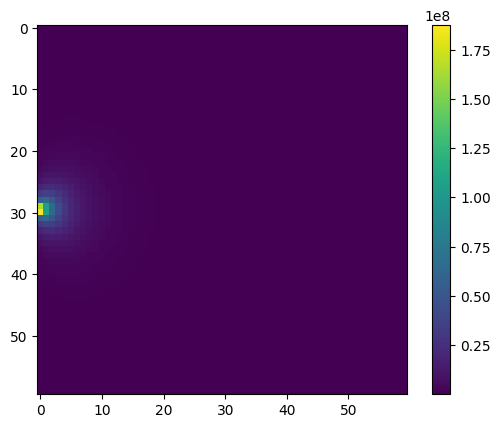

In [30]:
plt.imshow((res['flux'][0,:, :]))
plt.colorbar()
plt.show()

In [16]:
plt.hist(res['detp']['ppath'][:,0], bins=100, range=[0,200]);

KeyError: 'detp'

In [ ]:
from pmcx import dettime
arrival_times = dettime(res['detp'], prop=prop)

In [89]:
arrival_times.shape

(1, 48155)

In [ ]:
plt.hist(arrival_times[0,:], bins=100, range=[0, 0.5e-9])
plt.show()

In [ ]:
import jdata as jd

In [ ]:
shape=[]
shape.append({'Grid':{'Tag':1, 'Size':[40,60,30]}})
shape.append({'Sphere':{'Tag':2, 'O':[20,30,10], 'R':10}})

cfg['shapes']=jd.show({'Shapes':shape}, {'string':True})

In [ ]:
hist, bins = np.histogram(res['detp']['data'][0])
print("Histogram values:", hist)
print("Bins:", bins)

In [ ]:
res['detp']['detid'].shape

In [ ]:
res['detp']['data'].shape

In [ ]:
np.sum(res['detp']['data'][0] - res['detp']['detid'])

In [ ]:
plt.imshow(np.log10(res['flux'][30,:, :]))
plt.show()

In [ ]:
plt.imshow(np.log10(res['flux'][30,:, :]))
plt.show()

In [ ]:
def forward(volume, optical_properties, source_positions, source_directions, 
            detector_positions):
    """
    Implements the forward monte carlo solver.
    """

    config = {
        'nphoton': 1000000,
        'vol': volume,
        'tstart': 0,
        'tend': 1e-8,
        'tstep': 1e-8,
        'srcpos': source_positions,
        'srcdir': source_directions,
        'prop': optical_properties,
        'detpos': detector_positions,
        'replaydet':-1,
        'issavedet': 1,
        'issrcfrom0': 1,
        'issaveseed': 1,
        'unitinmm': 1.8,
        'maxdetphoton': 1000000000
    }

    result = pmcx.run(config)
    return result, config

def compute_jacobian(forward_result, config):
    
    config['seed']       = forward_result['seeds']  # one must define config['seed'] using the returned seeds
    config['detphotons'] = forward_result['detp']   # one must define config['detphotons'] using the returned detp data
    config['outputtype'] = 'jacobian'               # tell mcx to output absorption (μ_a) Jacobian

    result = pmcx.run(config)
    return result, config